## Композиции алгоритмов

Переименуйте ваше решение в формате <Фамилия>_<Имя>.ipynb, например Ivanov_Ivan.ipynb для удобства проверки. Вы присылаете только его, без данных и сопроводительных файлов. Оцениваются успешно запущенные вами результаты работы.

#### Возьмем датасет Ames c ценами на недвижимость, отберем из него 20 признаков. Будем предсказывать логарифм цены.

In [167]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X[features]
    return X, np.log(y)


X, y = load_ames_housing()

#### Разделим данные на обучающую и тестовую выборки (20% тестовая). 

In [168]:
random_state = 0
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
X_test.shape

(292, 20)

#### Применим StandardScaler к численным признакам и OneHotEncoder- к категориальным, используя sklearn `ColumnTransformer`

(пропущенные категориальные значения закодируем отдельной категорией, пропущенные численные - средним значением признака по тестовой выборке). 

In [169]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

numeric_features = numeric_data.columns
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [170]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (
    Ridge,
    RidgeCV,
    Lasso,
    LassoCV,
    HuberRegressor,
    ElasticNetCV,
)
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

### Реализуйте cтэкинг трех моделей,используя `sklearn.ensemble.StackingRegressor`: 
- KNeighborsRegressor(n_neighbors=2)
- LassoCV() 
- SVR(kernel='rbf')

В качестве финальной модели стэкинга используйте LinearRegression(fit_intercept=False), число блоков кросс-валидации StackingRegressor возьмите cv=3

Найдите лучшие параметры базовых моделей по сетке параметров:
    - KNN: n_neighbors: np.arange(1,16,5)
    - SVR:  kernel: 'rbf','poly'
    - LassoCV: [0.1,1]
 Используйте `GridSearchCV` со значениями параметров по умолчанию 
  
 #### Выведите:
 1. лучшие значения параметров n_neighbors, SVR, alpha
 2. MSE на тестовой выборке лучшей модели(точность 4 знака после запятой)
 3. базовую модель с максимальным весом в финальной  линейной модели и её вес (точность 4 знака после запятой)
 



In [171]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [172]:
param_grid = {
    "KNN__n_neighbors": np.arange(1, 16, 5),
    "SVR__kernel": ["rbf", "poly"],
    "Lasso__alphas": [[0.1, 1]],
}

stacking_regressor = StackingRegressor(
    estimators=[("KNN", KNeighborsRegressor()), ("Lasso", LassoCV()), ("SVR", SVR())],
    final_estimator=LinearRegression(),
    cv=3,
)

grid_search = GridSearchCV(estimator=stacking_regressor, param_grid=param_grid)

In [173]:
grid_search.fit(X_train_transf, y_train)

GridSearchCV(estimator=StackingRegressor(cv=3,
                                         estimators=[('KNN',
                                                      KNeighborsRegressor()),
                                                     ('Lasso', LassoCV()),
                                                     ('SVR', SVR())],
                                         final_estimator=LinearRegression()),
             param_grid={'KNN__n_neighbors': array([ 1,  6, 11]),
                         'Lasso__alphas': [[0.1, 1]],
                         'SVR__kernel': ['rbf', 'poly']})

In [174]:
# 1. лучшие значения параметров n_neighbors, SVR, alpha

best_KNN_n_neighbors = grid_search.best_estimator_.named_estimators_["KNN"].n_neighbors
best_SVR_kernel = grid_search.best_estimator_.named_estimators_["SVR"].kernel
best_Lasso_alpha = grid_search.best_estimator_.named_estimators_["Lasso"].alpha_

print(
    f"""
Best params:
KNN n_neighbors: {best_KNN_n_neighbors}
SVR kernel: {best_SVR_kernel}
Lasso alpha: {best_Lasso_alpha}
"""
)


Best params:
KNN n_neighbors: 1
SVR kernel: rbf
Lasso alpha: 0.1



In [175]:
#  2. MSE на тестовой выборке лучшей модели(точность 4 знака после запятой)
y_pred = grid_search.predict(X_test_transf)
print(f"MSE on test: {mean_squared_error(y_test, y_pred):.4f}")

MSE on test: 0.0241


In [176]:
#  3. базовую модель с максимальным весом в финальной  линейной модели и её вес (точность 4 знака после запятой)

max_weight_index = np.argmax(grid_search.best_estimator_.final_estimator_.coef_)
max_weight_model_name = list(grid_search.best_estimator_.named_estimators_.keys())[
    max_weight_index
]

print(
    f"Base model with max weight: {max_weight_model_name}\nWeight: {model_weights[max_weight_index]:.4f}"
)

Base model with max weight: SVR
Weight: 0.7526


### Реализуйте бэггинг решающих деревьев
С помощью функции `show_param_dependency` из модуля utility.py отобразите и  выберите сначала наилучшее значение max_features, затем max_samples,n_estimators. В каждом следующем подборе параметров используйте наилучшие параметры из предыдущих графиков.
Для подбора гиперпараметров max_features,max_samples,n_estimators разделите обучающую выборку на две: обучающую для бэггинга и валидационную (20% процентов валидационной от обучающей)

- для начала возьмите n_estimators=50
- используйте random_state=0 при разбиении train_test_split и в BaggingRegressor
- сетка для max_features: np.arange(1,max_features,3)
- сетка для n_estimators : np.arange(1,100,5)
- сетка для max_samples: np.arange(10,train_size,30)

#### Выведите:
4. лучший max_features 
5. лучший max_samples
6. лучший n_estimators
7. MSE на тестовой выборке

0| 5| 10| 14| 19| 24| 29| 33| 38| 43| 48| 52| 57| 62| 67| 71| 76| 81| 86| 90| 95| 100.0| 
Min MSE = 0.0254 for max_features=37


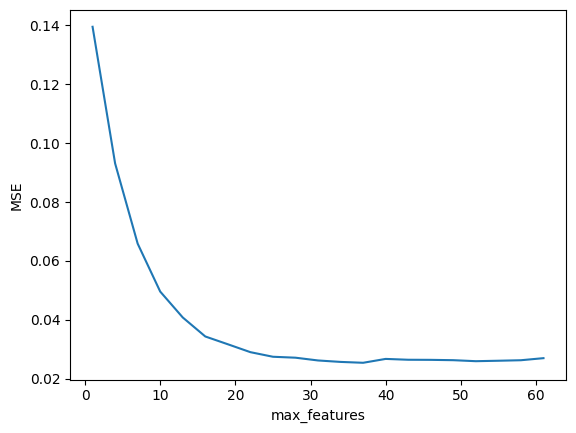

In [177]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from utility import show_param_dependency

X_train_bag_regr, X_val_bag_regr, y_train_bag_regr, y_val_bag_regr = train_test_split(
    X_train_transf, y_train, test_size=0.2, random_state=0
)

n_estimators = 50
max_features_best = None
max_samples_best = None

max_features_range = np.arange(1, X_train_bag_regr.shape[1] + 1, 3)

show_param_dependency(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=0),
        n_estimators=n_estimators,
        random_state=0,
    ),
    X_train_bag_regr,
    y_train_bag_regr,
    X_val_bag_regr,
    y_val_bag_regr,
    "max_features",
    max_features_range,
    "MSE",
)

0| 3| 6| 10| 13| 16| 19| 23| 26| 29| 32| 35| 39| 42| 45| 48| 52| 55| 58| 61| 65| 68| 71| 74| 77| 81| 84| 87| 90| 94| 97| 100.0| 
Min MSE = 0.0243 for max_samples=670


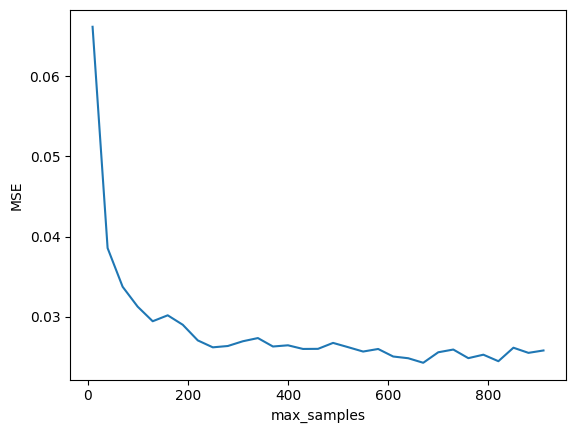

In [178]:
max_features_best = 37

max_samples_range = np.arange(10, len(X_train_bag_regr), 30)

show_param_dependency(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=0),
        n_estimators=n_estimators,
        max_features=max_features_best,
        random_state=0,
    ),
    X_train_bag_regr,
    y_train_bag_regr,
    X_val_bag_regr,
    y_val_bag_regr,
    "max_samples",
    max_samples_range,
    "MSE",
)

0| 5| 

10| 15| 20| 25| 30| 35| 40| 45| 50| 55| 60| 65| 70| 75| 80| 85| 90| 95| 100.0| 
Min MSE = 0.0242 for n_estimators=51


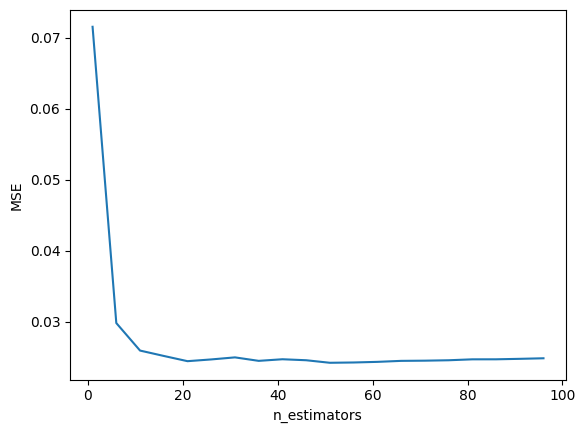

In [179]:
max_samples_best = 670

n_estimators_range = np.arange(1, 100, 5)

show_param_dependency(
    BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=0),
        max_features=max_features_best,
        max_samples=max_samples_best,
        random_state=0,
    ),
    X_train_bag_regr,
    y_train_bag_regr,
    X_val_bag_regr,
    y_val_bag_regr,
    "n_estimators",
    n_estimators_range,
    "MSE",
)

In [180]:
n_estimators_best = 51
final_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=0),
    n_estimators=n_estimators_best,
    max_features=max_features_best,
    max_samples=max_samples_best,
    random_state=0,
)
final_model.fit(X_train_transf, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=0),
                 max_features=37, max_samples=670, n_estimators=51,
                 random_state=0)

In [181]:
y_pred = final_model.predict(X_test_transf)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Best max_features: {max_features_best}")
print(f"Best max_samples: {max_samples_best}")
print(f"Best n_estimators: {n_estimators_best}")
print(f"MSE on test: {mse_test:.4f}")

Best max_features: 37
Best max_samples: 670
Best n_estimators: 51
MSE on test: 0.0246


### Реализуйте случайный лес
С помощью функции `show_param_dependency` из модуля utility.py отобразите и  выберите сначала наилучшее значение max_features, затем max_samples, потом n_estimators. В каждом следующем подборе параметров используйте наилучшие параметры из предыдущих графиков.
Для подбора гиперпараметров max_features, max_samples,n_estimators разделите обучающую выборку на две: обучающую для бэггинга и валидационную (20% процентов валидационной от обучающей)

- для начала возьмите n_estimators=50
- используйте random_state=0 при разбиении train_test_split и в RandomForestRegressor
- сетка для max_features: np.arange(1,max_features,3)
- сетка для n_estimators : np.arange(1,100,5)
- сетка для max_samples: np.arange(10,train_size,30)
После подбора параметров переобучите модель на всей обучающей выборке

#### Выведите:
8. лучший max_features 
9. лучший max_samples
10. лучший n_estimators
11. Коэффициент детерминации на тестовой выборке
12. Out of bag score на обучающей выборке

0| 5| 10| 14| 19| 24| 29| 33| 38| 43| 48| 52| 57| 62| 67| 71| 76| 81| 86| 90| 95| 100.0| 
Min MSE = 0.0242 for max_features=16


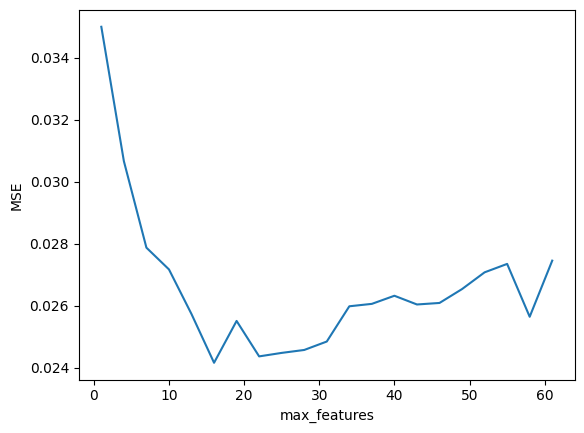

In [182]:
from sklearn.ensemble import RandomForestRegressor

X_train_RF, X_val_RF, y_train_RF, y_val_RF = train_test_split(
    X_train_transf, y_train, test_size=0.2, random_state=0
)

n_estimators = 50  # Начальное значение n_estimators
max_features_best = None
max_samples_best = None

max_features = X_train_RF.shape[1]  # Макс число признаков

max_features_range = np.arange(1, max_features + 1, 3)

show_param_dependency(
    RandomForestRegressor(n_estimators=n_estimators, random_state=0),
    X_train_RF,
    y_train_RF,
    X_val_RF,
    y_val_RF,
    "max_features",
    max_features_range,
    "MSE",
)

0| 3| 6| 10| 13| 16| 19| 23| 26| 29| 32| 35| 39| 42| 45| 48| 52| 55| 58| 61| 65| 68| 71| 74| 77| 81| 84| 87| 90| 94| 97| 100.0| 
Min MSE = 0.0231 for max_samples=790


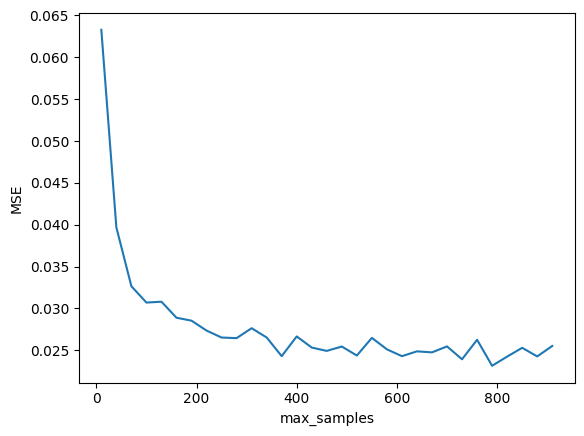

In [183]:
max_features_best = 16

train_size = len(X_train_RF)

max_samples_range = np.arange(10, train_size + 1, 30)

show_param_dependency(
    RandomForestRegressor(
        n_estimators=n_estimators, max_features=max_features_best, random_state=0
    ),
    X_train_RF,
    y_train_RF,
    X_val_RF,
    y_val_RF,
    "max_samples",
    max_samples_range,
    "MSE",
)

0| 5| 10| 15| 20| 25| 30| 35| 40| 45| 50| 55| 60| 65| 70| 75| 80| 85| 90| 95| 100.0| 
Min MSE = 0.0229 for n_estimators=76


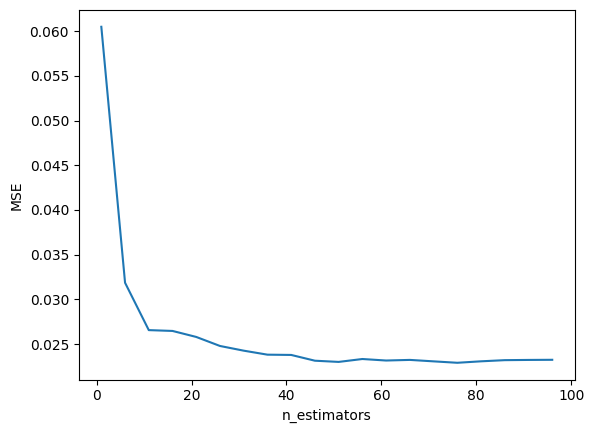

In [184]:
max_samples_best = 790
n_estimators_range = np.arange(1, 100, 5)

show_param_dependency(
    RandomForestRegressor(
        max_features=max_features_best,
        max_samples=max_samples_best,
        random_state=0,
    ),
    X_train_RF,
    y_train_RF,
    X_val_RF,
    y_val_RF,
    "n_estimators",
    n_estimators_range,
    "MSE",
)

In [185]:
n_estimators_best = 76

from sklearn.metrics import r2_score

final_model = RandomForestRegressor(
    n_estimators=n_estimators_best,
    max_features=max_features_best,
    max_samples=max_samples_best,
    random_state=0,
    oob_score=True,  # Out-of-Bag оценка
)

final_model.fit(X_train_transf, y_train)

RandomForestRegressor(max_features=16, max_samples=790, n_estimators=76,
                      oob_score=True, random_state=0)

In [186]:
y_pred = final_model.predict(X_test_transf)
r2_score_test = r2_score(y_test, y_pred)
oob_score = final_model.oob_score_

print(f"Best max_features: {max_features_best}")
print(f"Best max_samples: {max_samples_best}")
print(f"Best n_estimators: {n_estimators_best}")
print(f"Coef of determination: {r2_score_test:.4f}")
print(f"Out of bag score on test: {oob_score:.4f}")

Best max_features: 16
Best max_samples: 790
Best n_estimators: 76
Coef of determination: 0.8381
Out of bag score on test: 0.8148
